In [1]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from pathlib import Path
from utilities.helper_functions import accuracy_fn

from timeit import default_timer as timer

torch.__version__, torchvision.__version__

d:\Work\Coding\Machine-Learning\PyTorch\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


('2.7.1+cu118', '0.22.1+cu118')

## Device agnostic code

In [36]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Get FashionMNIST dataset

In [3]:
# setup training data
train_data = datasets.FashionMNIST(
    root="datasets",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

# setup testig data
test_data = datasets.FashionMNIST(
    root="datasets",
    train=False,
    download=True,
    transform=ToTensor()
)

In [4]:
# see first training sample
images, label = train_data[0]
images.shape, label

(torch.Size([1, 28, 28]), 9)

In [5]:
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(60000, 60000, 10000, 10000)

In [6]:
image, label = train_data[0]
classes= train_data.classes
# label = 9
label = classes[label]
label

'Ankle boot'

### Let's visualize

Image shape before squeeze: torch.Size([1, 28, 28])
Image shape after squeeze: torch.Size([28, 28])


Text(0.5, 1.0, 'Ankle boot')

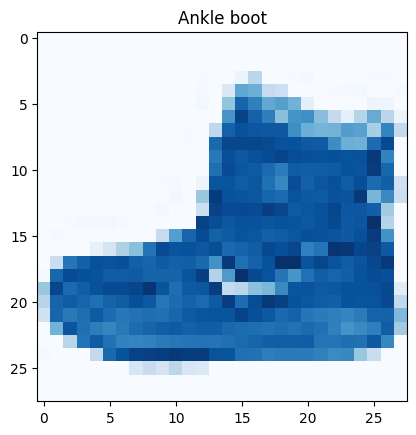

In [7]:
image, label = train_data[0]

print(f"Image shape before squeeze: {image.shape}")
image = image.squeeze()
print(f"Image shape after squeeze: {image.shape}")

plt.imshow(image, cmap=plt.cm.Blues)
plt.title(classes[label])

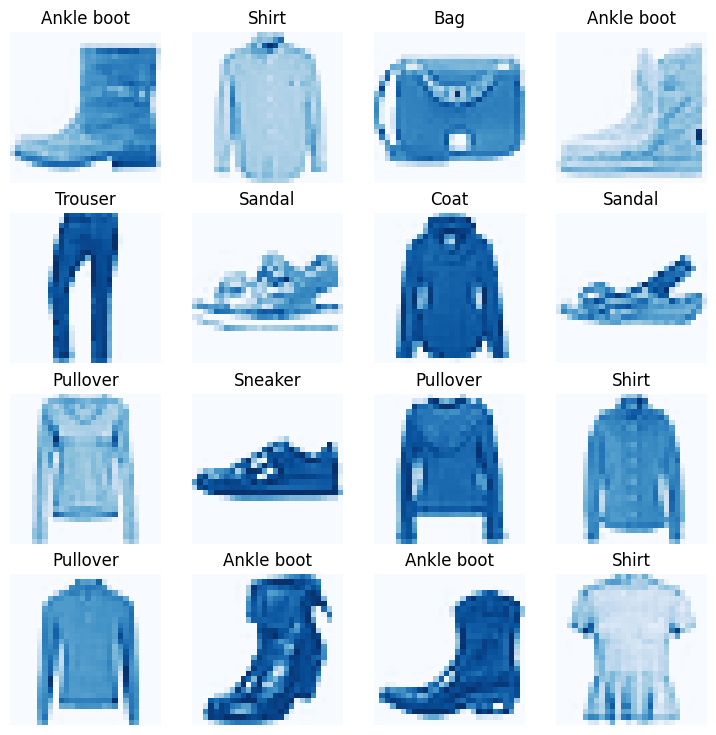

In [8]:
# plot more images

torch.manual_seed(42)

fig = plt.figure(figsize=(9, 9))

rows, cols = 4, 4

for i in range(1, rows*cols + 1):

    random_index = torch.randint(0, len(train_data), size=[1]).item()
    image, label = train_data[random_index]

    plt.subplot(rows, cols, i)
    plt.imshow(image.squeeze(), cmap=plt.cm.Blues)
    plt.title(classes[label])
    plt.axis(False)

## Prepare Dataloader

In [9]:
BATCH_SIZE = 32

train_dataloader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

test_dataloader = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    pin_memory=True
)

print(f"Dataloaders: {train_dataloader, test_dataloader}") 
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x00000263C9E1B990>, <torch.utils.data.dataloader.DataLoader object at 0x00000263C91BECD0>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


In [10]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [11]:
train_features_batch.permute(0, 2, 3, 1).shape

torch.Size([32, 28, 28, 1])

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

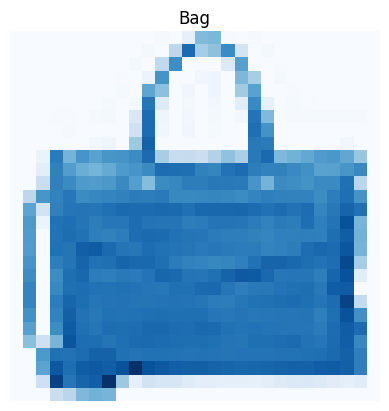

In [12]:

random_index = torch.randint(0, len(train_features_batch), size=[1]).item()

image, label = train_features_batch[random_index], train_labels_batch[random_index]

plt.title(classes[label])
plt.imshow(image.squeeze(), cmap=plt.cm.Blues)
plt.axis(False)

## Plot first batch

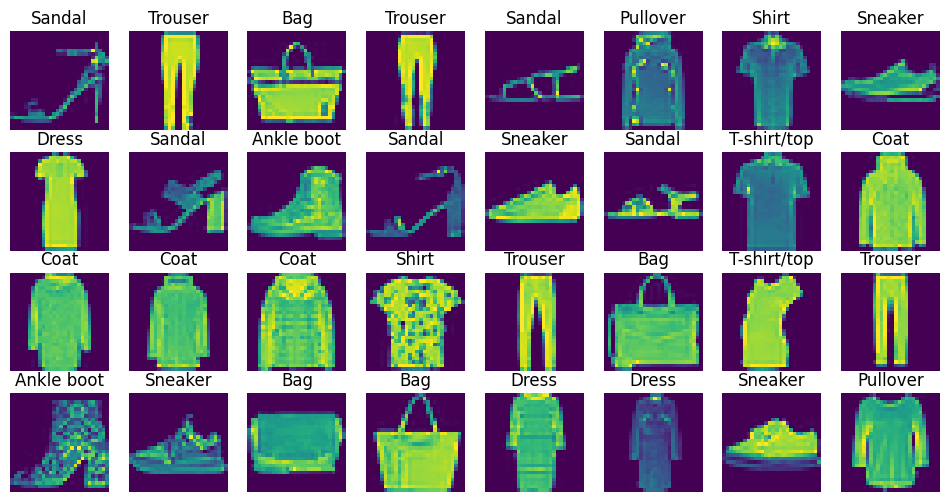

In [13]:
train_features_batch.shape, train_labels_batch.shape

rows, cols = 4, 8

plt.figure(figsize=(12,6))

for i in range(0, rows * cols):

    image, label = train_features_batch[i], train_labels_batch[i]
    
    plt.subplot(rows, cols, i + 1)

    plt.title(classes[label])
    plt.imshow(image.squeeze())
    plt.axis(False)

## Model 0: Build a baseline model

In [14]:
flatten_model = nn.Flatten()

x = train_features_batch[0]

output = flatten_model(x)


print(f"Shape before flattening: {x.shape} -> [color_channels, height, width]")
print(f"Shape after flattening: {output.shape} -> [color_channels, height*width]")

Shape before flattening: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Shape after flattening: torch.Size([1, 784]) -> [color_channels, height*width]


In [15]:
class FashionMNISTModelV0(nn.Module):

    def __init__(self, input_shape: int, output_shape: int, hidden_units: int):
        super().__init__()

        self.layer_stack = nn.Sequential(

            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )

    def forward(self, x: torch.tensor) -> torch.tensor:

        return self.layer_stack(x) 

In [16]:
torch.manual_seed(42)

model_0 = FashionMNISTModelV0(
    input_shape=784,
    hidden_units=10,
    output_shape=len(classes)
)

next(model_0.parameters()).device, model_0

(device(type='cpu'),
 FashionMNISTModelV0(
   (layer_stack): Sequential(
     (0): Flatten(start_dim=1, end_dim=-1)
     (1): Linear(in_features=784, out_features=10, bias=True)
     (2): Linear(in_features=10, out_features=10, bias=True)
   )
 ))

## Testing model_0 on random test dataset

In [17]:
X, y = next(iter(test_dataloader))
print(X.shape, y.shape)

pred = model_0(X)

pred.argmax(dim=1) == y

torch.Size([32, 1, 28, 28]) torch.Size([32])


tensor([False, False, False, False, False, False, False, False, False, False,
         True, False,  True, False,  True, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False])

## Setup loss, optimizer and evaluation metrics

In [18]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params= model_0.parameters(),
                            lr=0.01)

## Put model on GPU

In [19]:
# model_0.to(device)

# next(model_0.parameters()).device

## we'll compare time between the models using different devices

In [20]:
def print_train_time(start: float, end: float, device: torch.device = None):

    total_time = end - start
    print(f"Train time on {device}: {total_time: 3f} seconds")

    return total_time

In [21]:
def fit_fn(epochs):

    torch.manual_seed(42)

    train_time_start_on_cpu = timer()


    for epoch in tqdm(range(epochs)):

        print(f"Epoch: {epoch}\n-------")
        ### Training

        train_loss, train_accuracy = 0, 0

        for batch, (X, y) in enumerate(train_dataloader):

            # X = X.to(device)
            # y = y.to(device)
            # X = X.permute(0, 2, 3, 1)

            model_0.train()

            train_pred = model_0(X)

            loss = loss_fn(train_pred, y)

            train_loss += loss

            train_accuracy += accuracy_fn(y, train_pred.argmax(dim=1))

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            if batch % 400 == 0:

                print(f"Looket at: {batch * len(X)} / {len(train_dataloader.dataset)} samples")

        train_loss /= len(train_dataloader)

        train_accuracy /= len(train_dataloader)

        ## Testing

        test_loss, test_accuracy = 0, 0

        model_0.eval()

        with torch.inference_mode():

            for X, y in test_dataloader:

                # X = X.to(device)
                # y = y.to(device)
                # X = X.permute(0, 2, 3, 1)
                
                test_pred = model_0(X)

                loss = loss_fn(test_pred, y)

                test_loss += loss

            test_accuracy += accuracy_fn(y, test_pred.argmax(dim=1))

            test_loss /= len(test_dataloader)

            test_accuracy /= len(test_dataloader)

        print(f"Train Loss: {train_loss: .5f} --- | Test Loss: {test_loss: .5f} --- | Train Accuracy: {train_accuracy: .2f}% --- | Test Accuracy: {test_accuracy: .2f}%")

    train_time_end_on_cpu = timer()

    total_train_time_model_0 = print_train_time(train_time_start_on_cpu,
                                                train_time_end_on_cpu,
                                                device=str(next(model_0.parameters()).device))

In [22]:
fit_fn(3)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Looket at: 0 / 60000 samples
Looket at: 12800 / 60000 samples
Looket at: 25600 / 60000 samples
Looket at: 38400 / 60000 samples
Looket at: 51200 / 60000 samples


 33%|███▎      | 1/3 [00:16<00:33, 16.80s/it]

Train Loss:  0.90961 --- | Test Loss:  0.62902 --- | Train Accuracy:  70.87% --- | Test Accuracy:  0.28%
Epoch: 1
-------
Looket at: 0 / 60000 samples
Looket at: 12800 / 60000 samples
Looket at: 25600 / 60000 samples
Looket at: 38400 / 60000 samples
Looket at: 51200 / 60000 samples


 67%|██████▋   | 2/3 [00:31<00:15, 15.76s/it]

Train Loss:  0.55733 --- | Test Loss:  0.54409 --- | Train Accuracy:  81.09% --- | Test Accuracy:  0.28%
Epoch: 2
-------
Looket at: 0 / 60000 samples
Looket at: 12800 / 60000 samples
Looket at: 25600 / 60000 samples
Looket at: 38400 / 60000 samples
Looket at: 51200 / 60000 samples


100%|██████████| 3/3 [00:45<00:00, 15.32s/it]

Train Loss:  0.50266 --- | Test Loss:  0.51368 --- | Train Accuracy:  82.75% --- | Test Accuracy:  0.28%
Train time on cpu:  45.965865 seconds


# Train time on cpu:  37.191542 seconds
# Train time on cuda:0:  36.590398 seconds

## Models evaluation

In [56]:
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):

    loss, accuracy = 0, 0
    model.to(device)

    model.eval()

    with torch.inference_mode():

        for X, y in data_loader:

            X, y = X.to(device), y.to(device)
            
            logits = model(X)
            pred = logits.argmax(dim=1)

            loss += loss_fn(logits, y)
            accuracy += accuracy_fn(y, pred)


        loss /= len(data_loader)
        accuracy /= len(data_loader)

    return {
        "model_name": model.__class__.__name__,
        "model_loss": loss.item(),
        "model_accuracy": accuracy
    }

In [24]:
model_0_result = eval_model(model=model_0,
                            data_loader=test_dataloader,
                            loss_fn=loss_fn,
                            accuracy_fn=accuracy_fn)

model_0_result

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.5136751532554626,
 'model_accuracy': 81.9988019169329}

# Model 1: Building a better model with non-linearity

In [62]:
class FashionMNISTModelV1(nn.Module):

    def __init__(self, input_shape, hidden_units, output_shape, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.layer_stack = nn.Sequential(

            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )

    def forward(self, x: torch.tensor) -> torch.tensor:

        return self.layer_stack(x)

In [64]:
model_1 = FashionMNISTModelV1(
    input_shape=784,
    hidden_units=10,
    output_shape=len(classes)
).to(device)

model_1, next(model_1.parameters()).device

(FashionMNISTModelV1(
   (layer_stack): Sequential(
     (0): Flatten(start_dim=1, end_dim=-1)
     (1): Linear(in_features=784, out_features=10, bias=True)
     (2): ReLU()
     (3): Linear(in_features=10, out_features=10, bias=True)
     (4): ReLU()
     (5): Linear(in_features=10, out_features=10, bias=True)
   )
 ),
 device(type='cuda', index=0))

## Setup loss, optimizer and evaluation metrics

In [65]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(
    params=model_1.parameters(),
    lr=0.01
)

In [66]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    
        total_train_loss, total_train_accuracy = 0, 0
        model.to(device)

        for batch, (X, y) in enumerate(data_loader):
                
            X, y = X.to(device), y.to(device)

            model.train()

            train_logits = model(X)
            train_pred = train_logits.argmax(dim=1)
            train_loss = loss_fn(train_logits, y)
            
            total_train_loss += train_loss
            total_train_accuracy += accuracy_fn(y, train_pred)

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            if batch % 400 == 0:
                  
                print(f"{batch*len(X)} / {len(data_loader)*len(X)} samples remaining")

        total_train_loss /= len(data_loader)
        total_train_accuracy /= len(data_loader)
        
        print(f"Train Loss: {total_train_loss: .5f} ---| Train Accuracy: {total_train_accuracy: .2f}%")

def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              optimizer: torch.optim.Optimizer,
              accuracy_fn,
              device: torch.device = device):
      
        total_test_loss, total_test_accuracy = 0, 0
        model.to(device)

        model.eval()

        with torch.inference_mode():

            for batch, (X, y) in enumerate(data_loader):
                    
                X, y = X.to(device), y.to(device)

                test_logits = model(X)
                test_pred = test_logits.argmax(dim=1)
                test_loss = loss_fn(test_logits, y)

                total_test_loss += test_loss
                total_test_accuracy += accuracy_fn(y, test_pred)
            
                if batch % 200 == 0:
                  
                    print(f"{batch*len(X)} / {len(data_loader)*len(X)} samples remaining")

            total_test_loss /= len(data_loader)
            total_test_accuracy /= len(data_loader)

            print(f"Test Loss: {total_test_loss: .5f} --- | Test Accuracy: {total_test_accuracy: .2f}")

In [67]:
def fit_fn(model: torch.nn.Module,
           train_data_loader: torch.utils.data.DataLoader,
           test_data_loader: torch.utils.data.DataLoader,
           loss_fn: torch.nn.Module,
           optimizer: torch.optim.Optimizer,
           accuracy_fn,
           epochs: int,
           device: torch.device = device):

    train_time_start = timer()

    for epoch in tqdm(range(epochs)):

        print(f"Epoch: {epoch}")

        train_step(model=model,
                   data_loader=train_data_loader,
                   loss_fn=loss_fn,
                   optimizer=optimizer,
                   accuracy_fn=accuracy_fn)
        
        test_step(model=model,
                  data_loader=test_data_loader,
                  loss_fn=loss_fn,
                  optimizer=optimizer,
                  accuracy_fn=accuracy_fn)
        
    train_time_end = timer()

    print_train_time(start=train_time_start, 
                     end=train_time_end, 
                     device=device)

In [68]:
fit_fn(model=model_1,
       train_data_loader=train_dataloader,
       test_data_loader=test_dataloader,
       loss_fn=loss_fn,
       optimizer=optimizer,
       accuracy_fn=accuracy_fn,
       epochs=3)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
0 / 60000 samples remaining
12800 / 60000 samples remaining
25600 / 60000 samples remaining
38400 / 60000 samples remaining
51200 / 60000 samples remaining
Train Loss:  1.35122 ---| Train Accuracy:  48.84%
0 / 10016 samples remaining
6400 / 10016 samples remaining


 33%|███▎      | 1/3 [00:12<00:24, 12.24s/it]

Test Loss:  0.81938 --- | Test Accuracy:  69.43
Epoch: 1
0 / 60000 samples remaining
12800 / 60000 samples remaining
25600 / 60000 samples remaining
38400 / 60000 samples remaining
51200 / 60000 samples remaining
Train Loss:  0.70954 ---| Train Accuracy:  74.50%
0 / 10016 samples remaining
6400 / 10016 samples remaining


 67%|██████▋   | 2/3 [00:24<00:12, 12.12s/it]

Test Loss:  0.65755 --- | Test Accuracy:  76.84
Epoch: 2
0 / 60000 samples remaining
12800 / 60000 samples remaining
25600 / 60000 samples remaining
38400 / 60000 samples remaining
51200 / 60000 samples remaining
Train Loss:  0.60900 ---| Train Accuracy:  78.73%
0 / 10016 samples remaining
6400 / 10016 samples remaining


100%|██████████| 3/3 [00:37<00:00, 12.38s/it]

Test Loss:  0.59174 --- | Test Accuracy:  79.63
Train time on cuda:  37.130556 seconds


### Let's evaluate model

In [69]:
model_1_result = eval_model(model=model_1,
                            data_loader=test_dataloader,
                            loss_fn=loss_fn,
                            accuracy_fn=accuracy_fn,
                            device=device)
model_0_result, model_1_result

({'model_name': 'FashionMNISTModelV0',
  'model_loss': 0.5136751532554626,
  'model_accuracy': 81.9988019169329},
 {'model_name': 'FashionMNISTModelV1',
  'model_loss': 0.5917395353317261,
  'model_accuracy': 79.63258785942492})